# Image processing

Goal: from an image of an airfoil, generate sub-images of all tufts visible on the foil.

## 0. Setup

In [1]:
import numpy as np
from scipy import ndimage
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

%matplotlib inline

We start by testing out the display of images using the imported libraries.

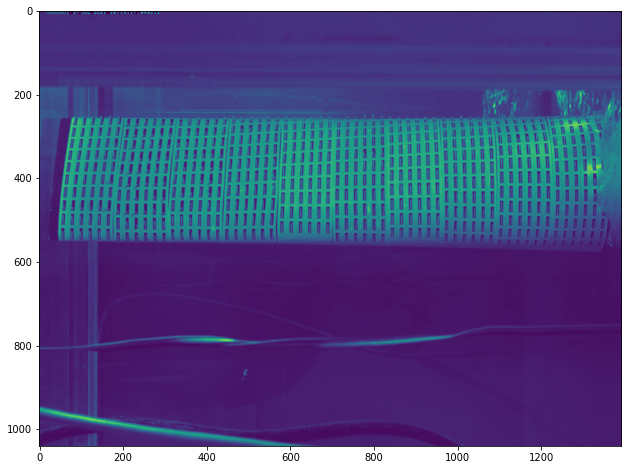

In [2]:
# Test out .tiff image display
#src = 'data/im0000_noflow.tiff'
src = 'data/im0001.tiff'

img = np.array(Image.open(src)).astype('float32')
plt.figure(figsize=(20,8))
plt.imshow(img)

## 1. Preliminary processing

The first step in isolating every tuft is cropping the image so the wing is prominently displayed. This ensures no other parts of the image produce noise or undesired outputs during the isolation process.

In [3]:
def rescale_image(img):
    """Rescale the image's grayscale values to the 0-1 range"""
    maxval = np.max(img)
    minval = np.min(img)
    return (img - minval)/(maxval - minval)


In [4]:
def show_wing(img, cmap='gray'):
    plt.figure(figsize=(20, 8))
    plt.imshow(img, cmap=cmap)

Rescaled image to [0.0; 1.0] range.


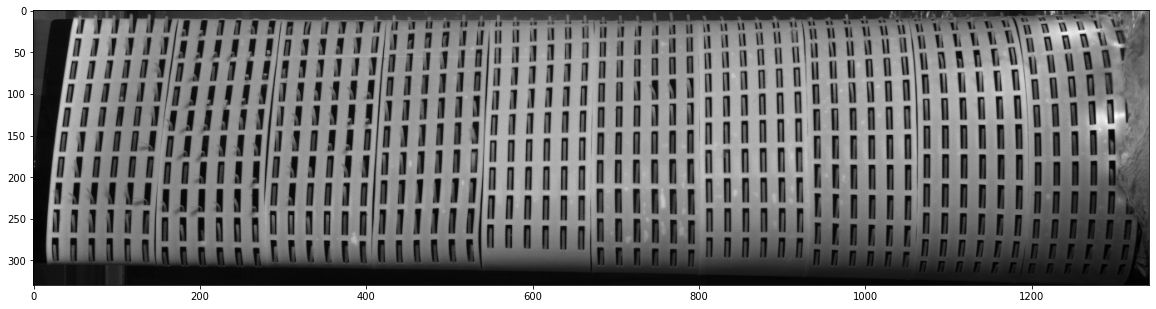

In [5]:
wing_img = img[245:575, 30:-20]

# We also rescale the values in the image to be able to
# work with the more common 0-1 range
wing_img = rescale_image(wing_img)

print('Rescaled image to [{}; {}] range.'.format(np.min(wing_img), np.max(wing_img)))

show_wing(wing_img)

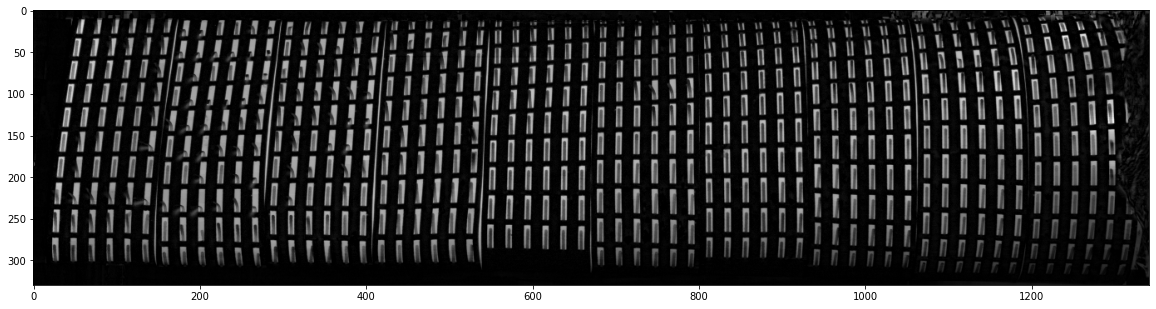

In [6]:
neg_img = 1 - wing_img.copy()

th_size = (10,10)

neg_img = ndimage.white_tophat(neg_img, size=th_size)

show_wing(neg_img)


In [7]:
def separate(img, factor):
    result = img.copy()
    result = ((img + 0.1)*(img - 1.1)) ** factor
    return np.abs(rescale_image(result))

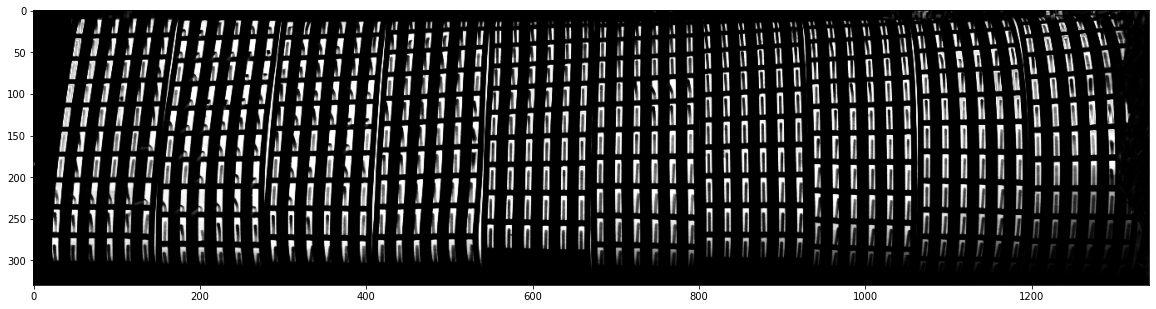

In [8]:
separated = separate(neg_img, 6)

show_wing(separated)

In [9]:
def threshold(img, thresh):
    result = img.copy()
    idx = result >= thresh
    result[idx] = 1
    result[~idx] = 0

    return result

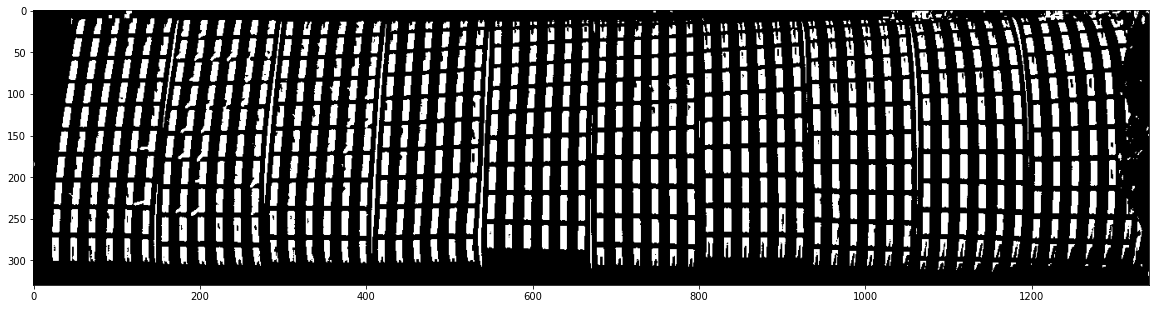

In [10]:
thresh = threshold(separated, 0.05)

show_wing(thresh)

In [11]:
def extract_blobs(img, radius, ratio_threshold):
    result = img.copy()
    total = ((2*radius + 1) ** 2) - 1
    for x in range(radius, len(img) - radius):
        for y in range(radius, len(img[0]) - radius):
            center = 1 if img[x, y] == 1 else 0
            n_white = np.count_nonzero(
                img[x-radius:x+radius, y-radius:y+radius]) - center
            r = n_white/total
            result[x, y] = 1 if r >= ratio_threshold else 0

    return result


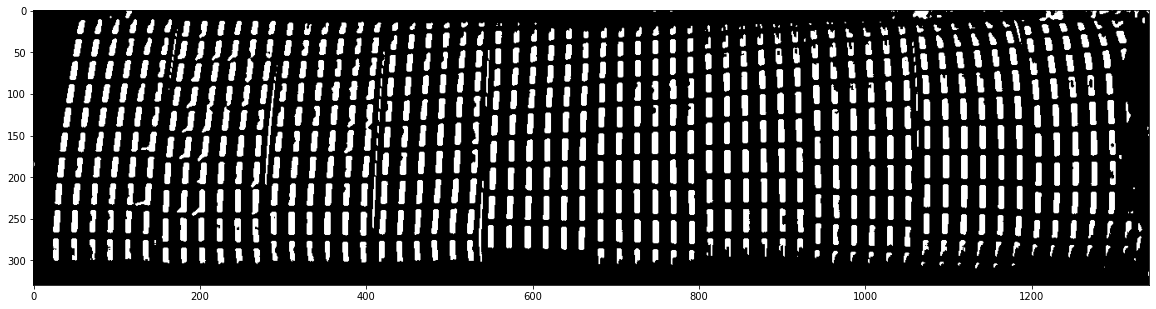

In [12]:
blobs = extract_blobs(thresh, 2, 0.35)

show_wing(blobs)

In [14]:
coord_comb = [(-1, -1), (-1,  0), (-1,  1),
              ( 0, -1),           ( 0,  1),
              ( 1, -1), ( 1,  0), ( 1,  1)]

In [15]:
def coordinates_are_valid(img, coords):
    x, y = coords
    return (x >= 0 and x < len(img) and y >= 0 and y < len(img[0]))

In [16]:
def get_blob_pixels(img, coords, pixel_set):
    """Returns a set of pixel coordinates which belong to a blob"""
    
    x, y = coords
    if (img[x, y] == 0) or ((x, y) in pixel_set):
        return set()
    else:
        pixel_set.add((x, y))
        for i, j in coord_comb:
            if (coordinates_are_valid(img, (x+i, y+j))):
                pixel_set.update(get_blob_pixels(img, (x+i, y+j), pixel_set))
        return pixel_set
    

In [17]:
def get_blob_extremes(pixel_set):
    x_vals, y_vals = zip(*list(pixel_set))
    return np.min(x_vals), np.max(x_vals), np.min(y_vals), np.max(y_vals)


In [22]:
def clean_blob(img, pixel_set):
    img[tuple(zip(*list(pixel_set)))] = 0


In [25]:
import pandas as pd

In [34]:
padding = 1

min_aspect_ratio = 1
max_aspect_ratio = 6

min_area = 50
max_area = 600

def blob_processor(pixel_set, img, base_img):
    xmin, xmax, ymin, ymax = get_blob_extremes(pixel_set)

    dim_x = xmax - xmin + 2*padding
    dim_y = ymax - ymin + 2*padding

    area = dim_x * dim_y
    aspect_ratio = dim_x / dim_y

    if (area < min_area or
        area > max_area or
        aspect_ratio < min_aspect_ratio or
        aspect_ratio > max_aspect_ratio):
        return False, None

    bb = (xmin - padding, xmax + padding, ymin - padding, ymax + padding)

    blob_entry = {
        'img': base_img[bb[0]:bb[1], bb[2]:bb[3]],
        'tuft': img[bb[0]:bb[1], bb[2]:bb[3]],
        'mean_pos_x': (xmax + xmin)/2,
        'mean_pos_y': (ymax + ymin)/2,
        'dim_x': dim_x,
        'dim_y': dim_y,
        'area': area,
        'aspect_ratio': aspect_ratio,
        'corner_x': xmin - padding,
        'corner_y': ymin - padding,
    }

    return True, blob_entry


In [44]:
def create_dataframe(img, base_img, blob_processor):
    results = []
    process_img = img.copy()

    while (np.any(process_img == 1)):
        coords = np.unravel_index(np.argmax(process_img == 1), process_img.shape)
        pixel_set = get_blob_pixels(process_img, (coords[0], coords[1]), set())
        is_valid, blob = blob_processor(pixel_set, img, base_img)
        if (is_valid):
            results.append(blob)
        
        clean_blob(process_img, pixel_set)

    results_df = pd.DataFrame(results)

    return results_df

In [36]:
blobs_df = create_dataframe(blobs, blob_processor)
blobs_df

,img,mean_pos_x,mean_pos_y,dim_x,dim_y,area,aspect_ratio,corner_x,corner_y
0,[],4.5,114.5,11,9,99,1.222222,-1,110
1,[],4.5,1275.0,11,8,88,1.375000,-1,1271
2,[],4.0,1326.5,10,7,70,1.428571,-1,1323
3,"[[0.531089, 0.51607054, 0.5026482, 0.49561054,...",19.5,78.0,19,10,190,1.900000,10,73
4,"[[0.49633607, 0.47188565, 0.46796778, 0.464340...",19.5,99.0,19,10,190,1.900000,10,94
...,...,...,...,...,...,...,...,...,...
574,"[[0.22803454, 0.055503156, 0.044620186, 0.0560...",296.0,964.0,16,8,128,2.000000,288,960
575,"[[0.140608, 0.049698904, 0.06297613, 0.0540520...",295.5,986.0,13,8,104,1.625000,289,982
576,"[[0.10012334, 0.11202206, 0.12921715, 0.123920...",293.5,1007.5,9,7,63,1.285714,289,1004
577,"[[0.13153885, 0.04012189, 0.04309657, 0.041718...",296.0,1029.0,12,8,96,1.500000,290,1025


In [38]:
def recomp_img(img, tufts_df):
    img = img.copy()


    for index, tuft in tufts_df.iterrows():
        img[tuft['corner_x']:tuft['corner_x']+tuft['dim_x'],
                tuft['corner_y']:tuft['corner_y']+tuft['dim_y']] = tuft['img']

    show_wing(img)


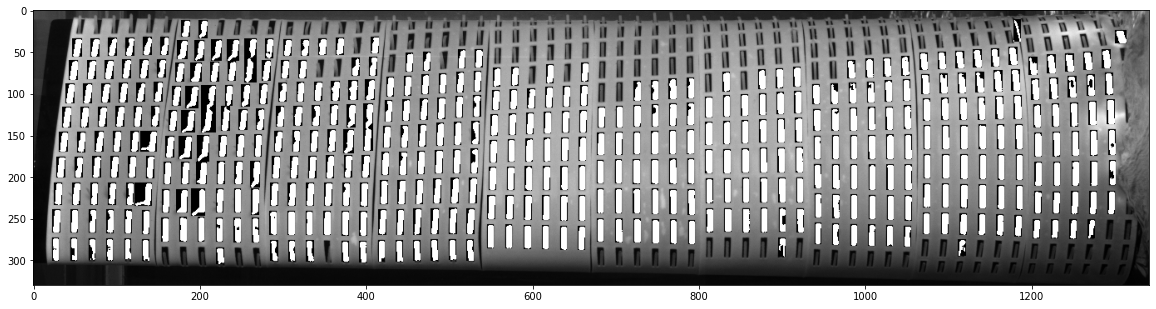

In [29]:
from scipy import stats

scalar_values = ['mean_pos_x', 'mean_pos_y', 'dim_x', 'dim_y']

z_scores = stats.zscore(blobs_df[scalar_values])
abs_z_scores = np.abs(z_scores)
"""
filtered_scores = abs_z_scores.loc[
    (abs_z_scores['dim_x'] <= 0.75) &
    (abs_z_scores['dim_y'] <= 3) &
    (abs_z_scores['mean_pos_x'] <= 2) &
    (abs_z_scores['mean_pos_y'] <= 2)
    ]
"""

aspect_ratio = 5
min_area = 200

"""
filtered_scores = blobs_df.loc[
    (blobs_df['dim_x'] > blob_dimensions['x']['min']) &
    (blobs_df['dim_x'] < blob_dimensions['x']['max']) &
    (blobs_df['dim_y'] > blob_dimensions['y']['min']) &
    (blobs_df['dim_y'] < blob_dimensions['y']['max'])
]
"""

filtered_scores = blobs_df.loc[
    (blobs_df['dim_x'] / blobs_df['dim_y'] <= aspect_ratio) &
    (blobs_df['dim_x'] * blobs_df['dim_y'] >= min_area)
]
tufts_df = blobs_df.iloc[filtered_scores.index]

recomp_img(wing_img, tufts_df)


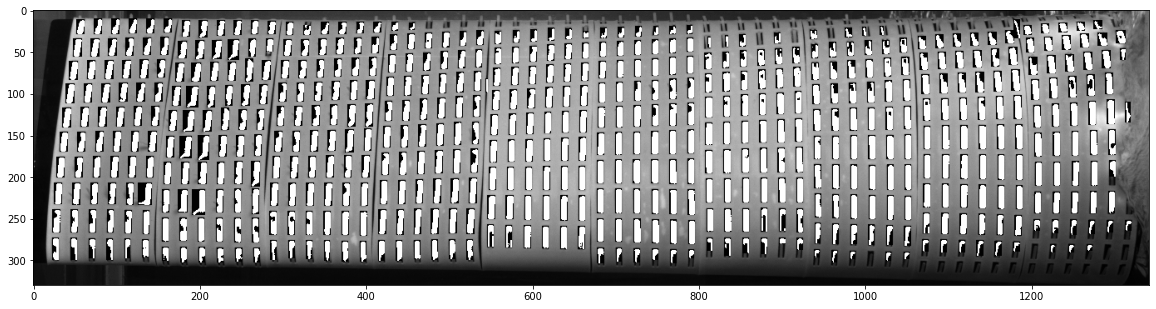

In [47]:
def pipeline(img):
    img = img.copy()

    # Crop
    img = img[245:575, 30:-20]

    # Rescale
    img = rescale_image(img)

    wing_base = img.copy()

    # Apply tophat transformation
    img = 1 - img
    th_size = (10, 10)
    img = ndimage.white_tophat(img, size=th_size)

    # Better separate values
    img = separate(img, 6)

    # Treshold image
    img = threshold(img, 0.1)

    # Extract blobs
    img = extract_blobs(img, 2, 0.35)
    
    # Create dataframe
    tufts_df = create_dataframe(img, blob_processor)

    recomp_img(wing_base, tufts_df)


src = 'data/im0001.tiff'

img = np.array(Image.open(src)).astype('float32')

pipeline(img)


We use edge detection to further crop the image.

In [ ]:
"""
scharr = [  
    [-3-3j, 0-10j, 3-3j],   
    [-10+0j, 0+0j, 10+0j],
    [-3+3j, 0+10j, 3+3j]
        ]
"""
